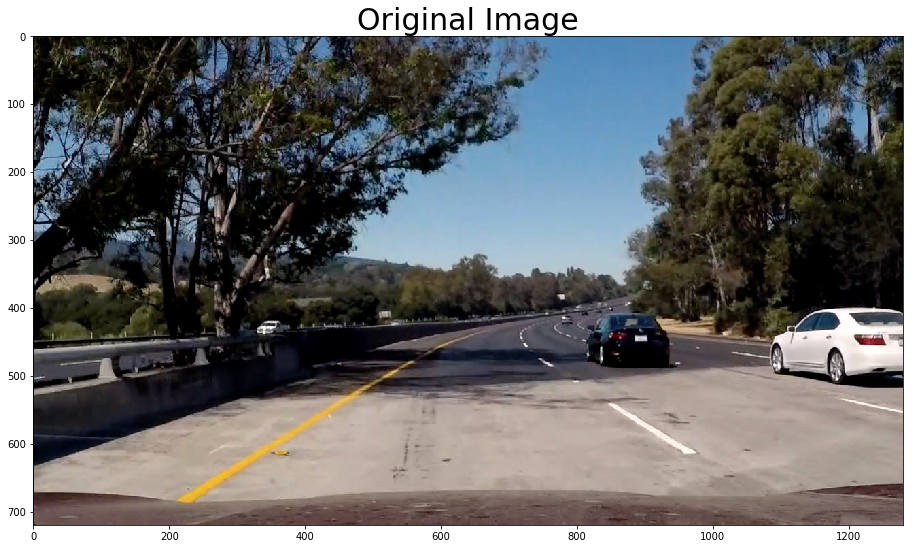

In [86]:
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


serialize = pickle.load( open( "calibrate_matrix.pickle", "rb" ) )
mtx = serialize["mtx"]
dist = serialize["dist"]

# Check for calibration
# Compare the images post undistort
img_BGR = cv2.imread('test_images/test5.jpg')
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Show Single Image
def show_img(img, title, isGray=False):
    plt.figure(figsize=(24,9))
    if isGray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title, fontsize=30)

show_img(img_RGB, 'Original Image')

Text(0.5,1,'Gray')

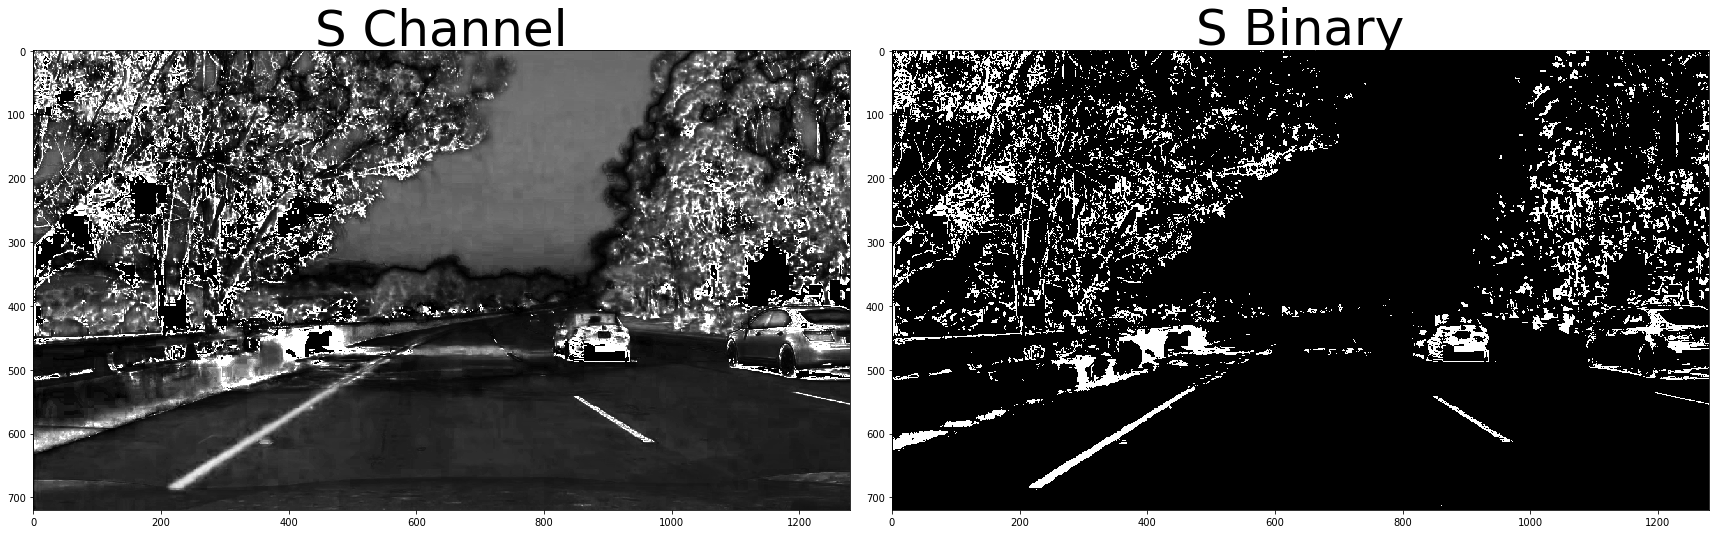

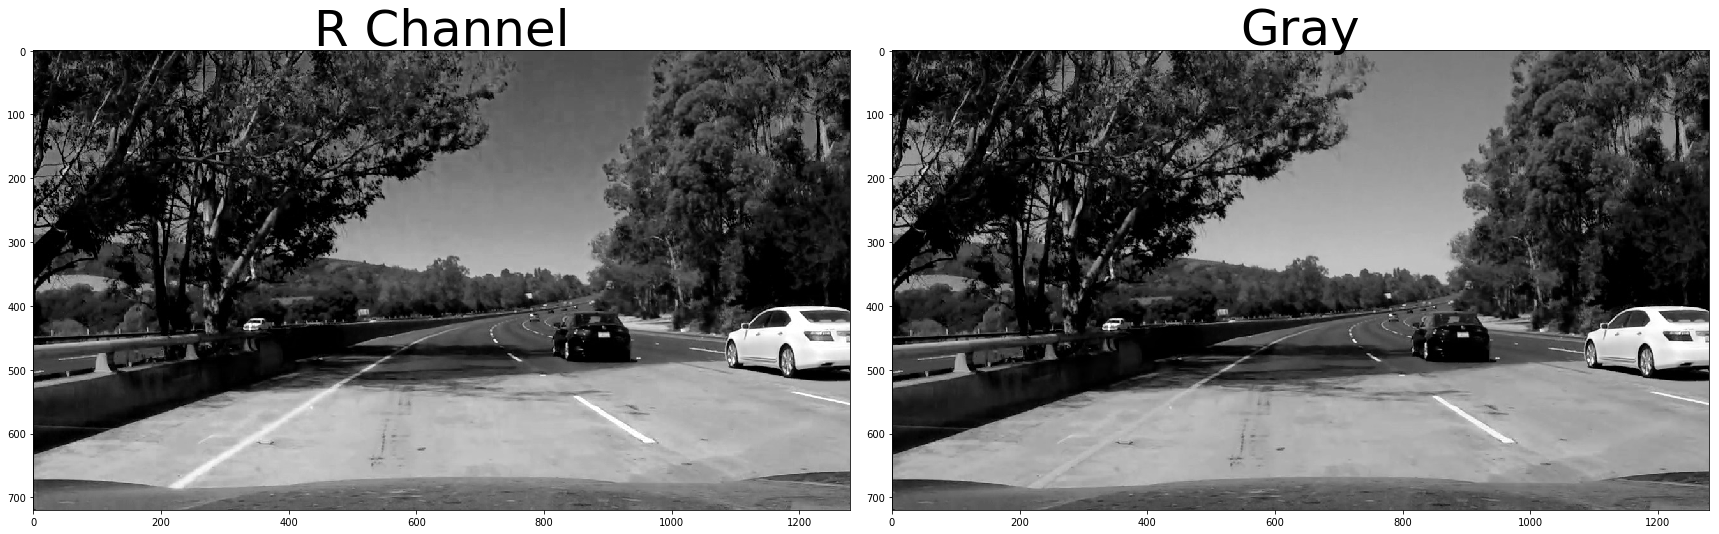

In [87]:
# Perform color threshold
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

hls = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HLS)
S = hls[:,:,2]

hls_binary = hls_select(img_BGR, thresh=(150, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S, cmap='gray')
ax1.set_title('S Channel', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('S Binary', fontsize=50)

R = img_RGB[:,:,0]

f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f2.tight_layout()
ax3.imshow(R, cmap='gray')
ax3.set_title('R Channel', fontsize=50)
ax4.imshow(cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY), cmap='gray')
ax4.set_title('Gray', fontsize=50)

In [88]:
# Define all the Sobel functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale (RGB to grayscale)
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobelxy = np.sqrt(np.square(sobelx)+ np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
       # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    #sobelxy = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(sobelxy)
    sxbinary[(sobelxy >= thresh[0]) & (sobelxy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

Text(0.5,1,'Mag Gray')

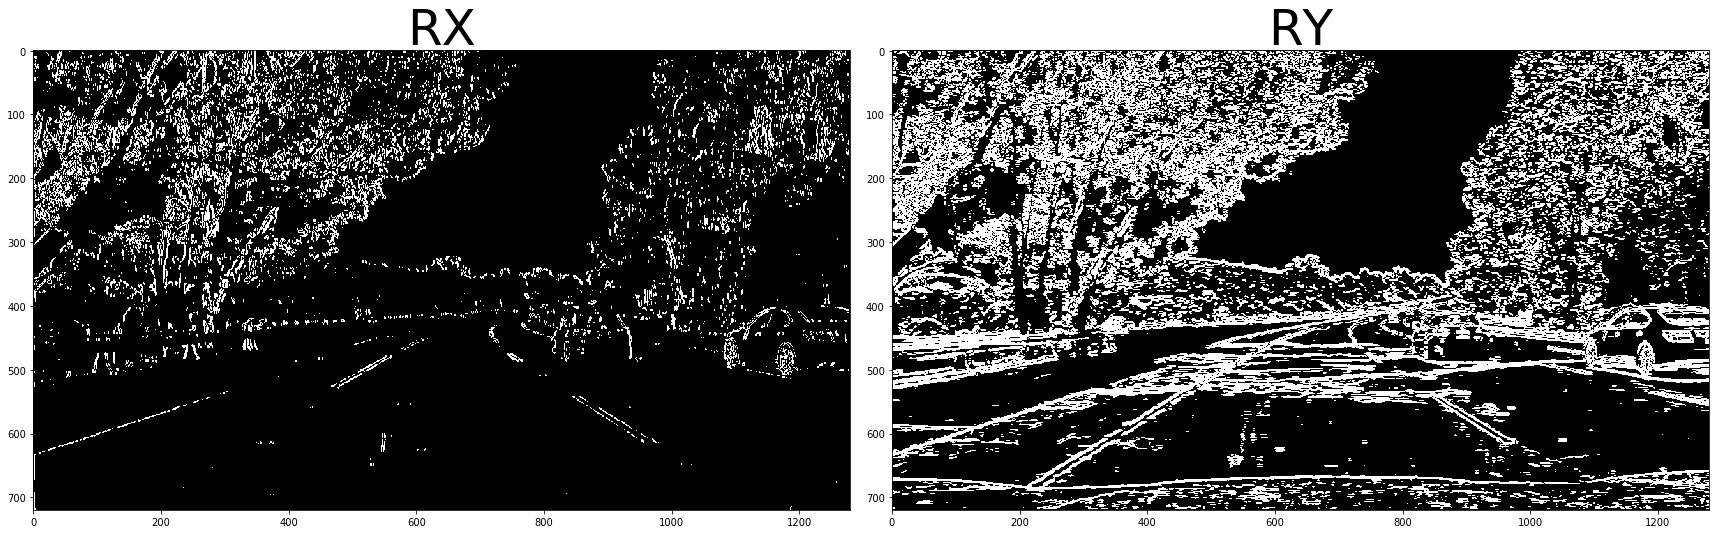

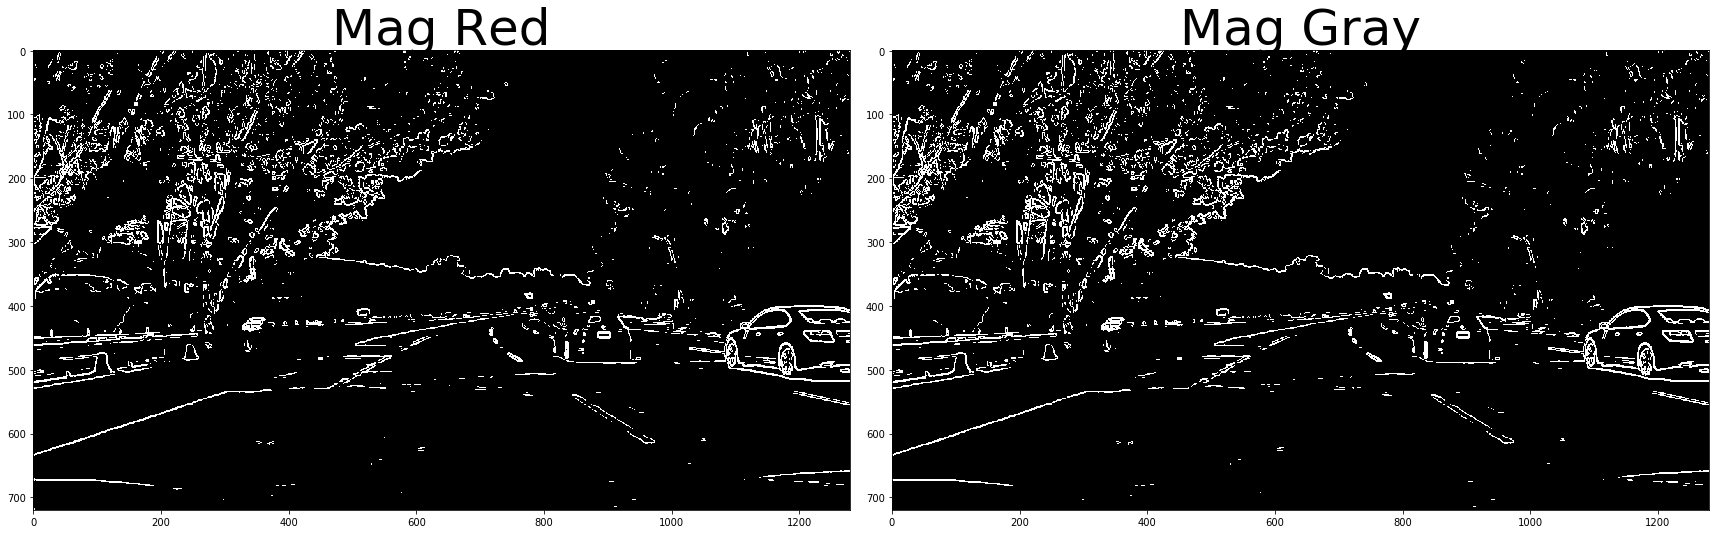

In [97]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(R, orient='y', sobel_kernel=ksize, thresh=(10, 200))
mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(55, 255))
mag_binary_gray = mag_thresh(cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY), sobel_kernel=ksize, mag_thresh=(55, 255))
#dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(.7, 1.3))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('RX', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('RY', fontsize=50)

f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f2.tight_layout()
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Mag Red', fontsize=50)
ax4.imshow(mag_binary_gray, cmap='gray') # similar in performance to R channel
ax4.set_title('Mag Gray', fontsize=50) 
#ax4.set_title('Dir', fontsize=50) - Lot of noise

In [98]:

# Plot the contributions
# show_img(gradx, 'GrayX', True)
# show_img(grady, 'GrayY', True)
# show_img(mag_binary, 'Mag', True)
# show_img(dir_binary, 'Dir', True)

Text(0.5,1,'Combined')

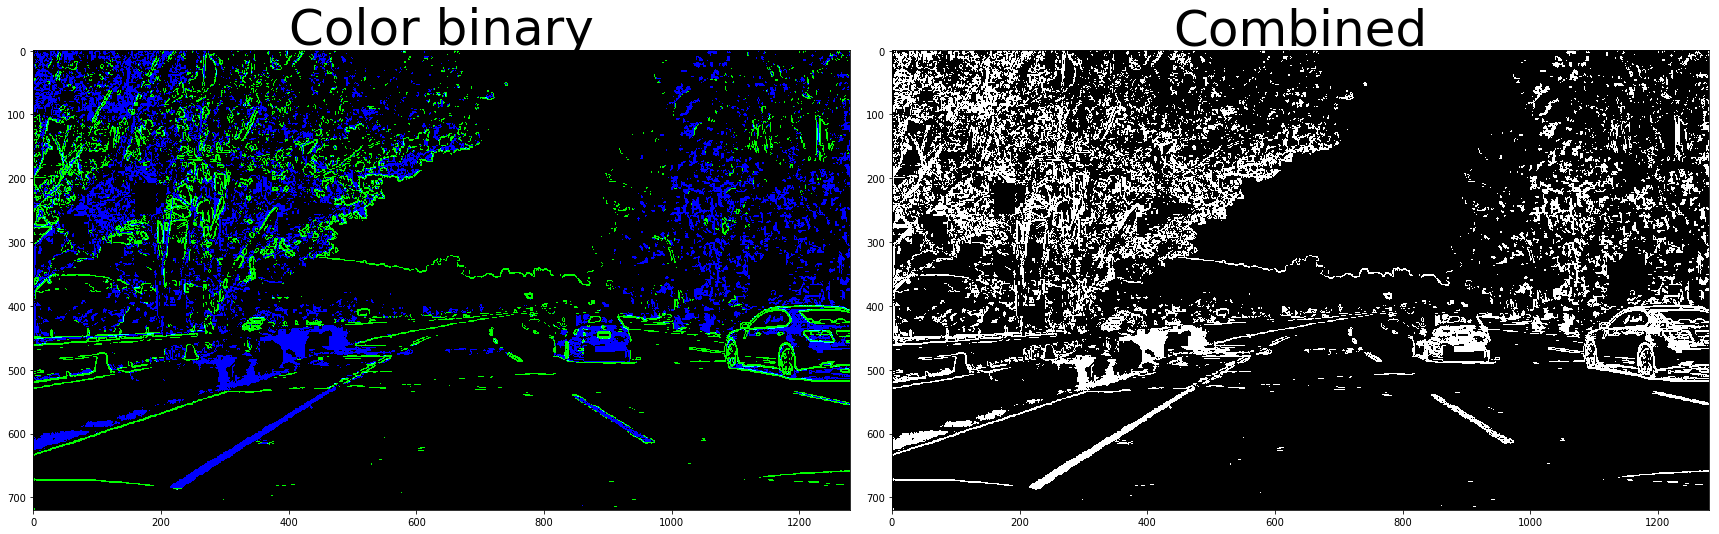

In [99]:
# 
combined = np.zeros_like(mag_binary)
# Color stack
color_binary = np.dstack(( np.zeros_like(gradx), mag_binary, hls_binary)) * 255
# Combined 
combined[((hls_binary == 1) | (mag_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Color binary', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)